In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import IPython
import re
import json
from time import sleep
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('bmh')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from difflib import SequenceMatcher
import spacy
from langchain.text_splitter import RecursiveCharacterTextSplitter  
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

### **Funções** 

In [2]:
def minute_json(date_minute: str):
    """
    Realiza o web scraping das atas do COPOM.

    Parameters:
    date_minute (str): data de publicação no formato 'ddmmyyyy'.

    Returns:
    Objeto json do texto do COPOM.

    """
    url = f'https://www.bcb.gov.br/api/servico/sitebcb/copomminutes/principal?filtro=IdentificadorUrl%20eq%20%27{date_minute}%27'
        
    headers = {
        "authority": "www.bcb.gov.br",
        "accept": "application/json, text/plain, */*",
        "accept-language": "pt-BR,pt;q=0.9",
        "cookie": "TS01d9825e=012e4f88b36cce3651c602c46f3e3dcf2c6e53409aad20d4028657ad6c0ce74f163bd591ec1ebae4c2224d16a5510b53756786b3b0; dtLatC=1; dtPC=-; TS01c46804=012e4f88b3da9e1e50438b217c16cd55dd2e13e2ebe839f4e95c012790098b9fb734a1d9fab097738b4c355d9c8a444d65d548285629cdca0e66b95ab0bfd7ecc10387d2b4cc65a5e23ab422e6946c0e01e97c458a; dtCookie=v_4_srv_1_sn_1BEC291D8A0D6B90B90E0418D5AC1813_perc_100000_ol_0_mul_1_app-3Asgs_1_app-3A262a693a3e337a24_1^|c2dzfDE; dtSa=true^%^7CKD17^%^7C-1^%^7Ctexto^%^7C-^%^7C1693916845380^%^7C116732625_395^%^7Chttps^%^3A^%^2F^%^2Fwww3.bcb.gov.br^%^2Fsgspub^%^2Flocalizarseries^%^2FlocalizarSeries.do^%^3Fmethod^%^3DprepararTelaLocalizarSeries^%^7CSGS^%^20-^%^20Sistema^%^20Gerenciador^%^20de^%^20S^%^C3^%^A9ries^%^20Temporais^%^7C1693916734678^%^7C",
        "if-none-match": "W/^\^2bc4b976-98e8-41ba-97cc-ebf522d9a013^^",
        "referer": "https://www.bcb.gov.br/en/publications/copomminutes",
        "sec-ch-ua": "^\^Chromium^^;v=^\^116^^, ^\^Not"
    }

    r = requests.request("GET", url, headers=headers)
    data = r.json()

    # Título da ata -> '255th Meeting - June 20-21, 2023'
    titulo_minute = data['conteudo'][0]['Titulo']
    # Selecionando apenas o nº da ata
    num_minute = re.findall(r'(\d+)(?:st|nd|rd|th)', titulo_minute)[0]

    # Texto com elementos HTML (c/ elementos HTML) -> Exemplo: '<div id="atacompleta"><div id="ataconteudo"><h3 class="secao">A) Update of economic outlook and Copom’s scenario<sup>1</sup></h3><p class="paragrafo">1. 
    text_minute = data['conteudo'][0]['OutrasInformacoes']

    # Usando o BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(text_minute, 'html.parser')
    # Extraindo o texto principal sem elementos HTML
    minute_text = soup.get_text()

    # Criando um dicionário com uma chave para o texto p/ transformar em um arquivo JSON
    dados = {f'minute_{num_minute}': minute_text}

    with open(f'C://Users//vitor//projetos_python//python_b3//nlp-ata-copom//analise-ata-copom//copom//minutes-json//minute_{num_minute}.json', 'w', encoding='utf-8') as arquivo_json:
        json.dump(dados, arquivo_json)
    
    sleep(2)


def minute_copom(text_minute: str):
    """
    Formatando o texto do minute em seis partes: completo, título 'A', título 'B', título 'C', título 'D' e notas do rodapé.
    Essa função serve apenas até a ata 246 até a mais atual.

    Parameters:
    text_minute: texto do minute publicado pelo BC.

    Returns:
    Dataframes do texto do minute (completo, título 'A', título 'B', título 'C', título 'D')
    
    """
    # Descobrindo a posição (index) da 1º palavra dos títulos de cada arquivo 'A)', 'B)', 'C)', 'D)'
    word_a = 'A)'
    position_a_init = text_minute.find(word_a)

    word_b = 'B)'
    position_b_init = text_minute.find(word_b)  

    word_c = 'C)'
    position_c_init = text_minute.find(word_c)

    word_d = 'D)'
    position_d_init = text_minute.find(word_d)

    word_footnote = 'Footnotes'
    position_footnote_init = text_minute.find(word_footnote)

    # Tamanho do título. Isso servirá para eu somar com a posição inicial de cada título ('A)', 'B)', 'C)', 'D)')
    # Com isso, os textos de cada título se iniciaram já no tópico ('1. The global environment remains...')
    # E não mais no título+tópico ('A) Update of economic outlook and Copom’s scenario11. The global environment remains...')
    len_titulo_a = len('A) Update of economic outlook and Copom’s scenario1')
    len_titulo_b = len('B) Scenarios and risk analysis')
    len_titulo_c = len('C) Discussion about the conduct of monetary policy')
    len_titulo_d = len('D) Monetary policy decision')

    # Minute completo não editado
    complete_minute = text_minute[:]
    #len_complete_minute = len(complete_minute)

    # A) Update of economic outlook and Copom's scenario
    minute_a = text_minute[position_a_init + len_titulo_a: position_b_init]
    #len_minute_a = len(minute_a)

    # B) Scenarios and risk analysis
    minute_b = text_minute[position_b_init + len_titulo_b : position_c_init]
    #len_minute_b = len(minute_b)

    # C) Discussion about the conduct of monetary policy
    minute_c = text_minute[position_c_init + len_titulo_c : position_d_init]
    #len_minute_c = len(minute_c)

    # D) Monetary policy decision
    minute_d = text_minute[position_d_init + len_titulo_d : position_footnote_init]
    #len_minute_d = len(minute_d)

    # Footnote
    minute_footnote = text_minute[position_footnote_init:]

    # Os tópicos que estão no meio do texto tem esse padrão que é estar entre dois pontos ('.2' -> ex:'...by emerging countries.2. Regarding the domestic...)
    # Usando o regex, eu consigo achar esse padrão ('.número.') e quebrar a linha antes do número
    minute_a = re.sub(r'\.(\d+\.)', r'\n\1', minute_a)
    minute_b = re.sub(r'\.(\d+\.)', r'\n\1', minute_b)
    minute_c = re.sub(r'\.(\d+\.)', r'\n\1', minute_c)
    minute_d = re.sub(r'\.(\d+\.)', r'\n\1', minute_d)

    # Após fazer a quebra entre os tópicos, o tópico anterior acaba ficando sem um ponto final na frase. 
    # Adicionando um ponto final nos tópicos que vem antes de uma quebra de linha, exceto no último tópico
    topicos_a = minute_a.split('\n')
    topicos_b = minute_b.split('\n')
    topicos_c = minute_c.split('\n')
    topicos_d = minute_d.split('\n')

    topicos_a_formatado = [topico + '.' if i < len(topicos_a) - 1 else topico for i, topico in enumerate(topicos_a)]
    topicos_b_formatado = [topico + '.' if i < len(topicos_b) - 1 else topico for i, topico in enumerate(topicos_b)]
    topicos_c_formatado = [topico + '.' if i < len(topicos_c) - 1 else topico for i, topico in enumerate(topicos_c)]
    topicos_d_formatado = [topico + '.' if i < len(topicos_d) - 1 else topico for i, topico in enumerate(topicos_d)]

    # Juntando os tópicos novamente em um único texto para cada título
    minute_a = '\n'.join(topicos_a_formatado)
    minute_b = '\n'.join(topicos_b_formatado)
    minute_c = '\n'.join(topicos_c_formatado)
    minute_d = '\n'.join(topicos_d_formatado)

    # Com todos os títulos topificados corretamente, juntando todos os títulos em apenas um texto (minute completo editado)
    complete_minute_final = minute_a + '\n' + minute_b + '\n' + minute_c + '\n' + minute_d

    return complete_minute_final, minute_a, minute_b, minute_c, minute_d 


def minute_copom_v2(text_minute: str):
    """
    Formatando o texto do minute em seis partes: completo, título 'A', título 'B', título 'C', título 'D' e notas do rodapé.
    Nessa função, eu estou mudando manualmente os títulos da ata.

    Parameters:
    text_minute: texto do minute publicado pelo BC.

    Returns:
    Dataframes do texto do minute (completo, título 'A', título 'B', título 'C', título 'D')
    
    """
    # Descobrindo a posição (index) da 1º palavra dos títulos de cada arquivo 'A)', 'B)', 'C)', 'D)'
    word_a = 'A)'
    position_a_init = text_minute.find(word_a)

    word_b = 'B)'
    position_b_init = text_minute.find(word_b)  

    word_c = 'C)'
    position_c_init = text_minute.find(word_c)

    word_d = 'D)'
    position_d_init = text_minute.find(word_d)

    word_footnote = 'Footnotes'
    position_footnote_init = text_minute.find(word_footnote)

    # Minute completo não editado
    complete_minute = text_minute[:]
    #len_complete_minute = len(complete_minute)

    # A) Update of economic outlook and Copom's scenario
    minute_a = text_minute[position_a_init : position_b_init]
    #len_minute_a = len(minute_a)

    # B) Scenarios and risk analysis
    minute_b = text_minute[position_b_init : position_c_init]
    #len_minute_b = len(minute_b)

    # C) Discussion about the conduct of monetary policy
    minute_c = text_minute[position_c_init : position_d_init]
    #len_minute_c = len(minute_c)

    # D) Monetary policy decision
    minute_d = text_minute[position_d_init : position_footnote_init]
    #len_minute_d = len(minute_d)

    # Footnote
    minute_footnote = text_minute[position_footnote_init:]

    # Os tópicos que estão no meio do texto tem esse padrão que é estar entre dois pontos ('.2' -> ex:'...by emerging countries.2. Regarding the domestic...)
    # Usando o regex, eu consigo achar esse padrão ('.número.') e quebrar a linha antes do número
    minute_a = re.sub(r'\.(\d+\.)', r'\n\1', minute_a)
    minute_b = re.sub(r'\.(\d+\.)', r'\n\1', minute_b)
    minute_c = re.sub(r'\.(\d+\.)', r'\n\1', minute_c)
    minute_d = re.sub(r'\.(\d+\.)', r'\n\1', minute_d)

    # Após fazer a quebra entre os tópicos, o tópico anterior acaba ficando sem um ponto final na frase. 
    # Adicionando um ponto final nos tópicos que vem antes de uma quebra de linha, exceto no último tópico
    topicos_a = minute_a.split('\n')
    topicos_b = minute_b.split('\n')
    topicos_c = minute_c.split('\n')
    topicos_d = minute_d.split('\n')

    topicos_a_formatado = [topico + '.' if i < len(topicos_a) - 1 else topico for i, topico in enumerate(topicos_a)]
    topicos_b_formatado = [topico + '.' if i < len(topicos_b) - 1 else topico for i, topico in enumerate(topicos_b)]
    topicos_c_formatado = [topico + '.' if i < len(topicos_c) - 1 else topico for i, topico in enumerate(topicos_c)]
    topicos_d_formatado = [topico + '.' if i < len(topicos_d) - 1 else topico for i, topico in enumerate(topicos_d)]

    # Juntando os tópicos novamente em um único texto para cada título
    minute_a = '\n'.join(topicos_a_formatado)
    minute_b = '\n'.join(topicos_b_formatado)
    minute_c = '\n'.join(topicos_c_formatado)
    minute_d = '\n'.join(topicos_d_formatado)

    # Com todos os títulos topificados corretamente, juntando todos os títulos em apenas um texto (minute completo editado)
    complete_minute_final = minute_a + '\n' + minute_b + '\n' + minute_c + '\n' + minute_d

    return complete_minute_final, minute_a, minute_b, minute_c, minute_d 


def wordcloud_copom(minute: str):
    """
    Criação do wordcloud do texto da ata do COPOM.

    Parameters:
    minute (str): texto da ata do COPOM.

    Returns:
    Figura do wordcloud da ata do COPOM.
    """
    # Transformando todo o texto da ata em letra minúscula
    minute_text = minute.lower()

    # Plotando o wordcloud
    plt.figure(figsize=(15,15))
    wc = WordCloud(background_color="purple", stopwords = STOPWORDS, max_words=50, max_font_size= 300,  width=1600, height=800)
    wc.generate(minute_text)
    plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
    plt.axis('off')

    return plt.show();


def text_splitter(minute: str):
    """
    Separa o texto em várias partes.

    Parameters:
    minute (str): texto da ata do COPOM.

    Returns:
    Retorna as "partes" do texto separados dentro de uma lista.

    NOTE:
    Essa função 'RecursiveCharacterTextSplitter' separa o texto bem parecido com a função do nltk 'sent_tokenize()'.
    Porém, essa função não separa os números dos tópicos do texto.
    Exemplo: 'RecursiveCharacterTextSplitter' -> ['1. The global environment remains uncertain, with some disinflation at the margin but ...']
             'sent_tokenize' -> ['1.', 'The global environment remains uncertain, with some disinflation at the margin but ...']

    """
    # https://github.com/langchain-ai/text-split-explorer
    length_function = len

    # The default list of split characters is [\n\n, \n, " ", ""]
    # Tries to split on them in order until the chunks are small enough
    # Keep paragraphs, sentences, words together as long as possible
    splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=1000, 
        chunk_overlap=200,
        length_function=length_function,
    )

    text = minute
    splits = splitter.split_text(text)

    return splits


def sentiment_score(sentence: str):
  """
  Análise de sentimento do texto da ata do COPOM. Utiliza um modelo específico para finanças de análise de sentimento.
  Modelo utilizado: https://huggingface.co/ahmedrachid/FinancialBERT-Sentiment-Analysis

  Parameters:
  sentence (str): texto da ata do COPOM.

  Returns:
  Retorna o sentimetno do texto da ata do COPOM - pode ser positivo, negativo ou neutro.

  """
  tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

  model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)

  nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

  results = nlp(sentence)
  
  return results[0]['label']


def sentiment_score_v2(sentence: str):
  """
  Análise de sentimento do texto da ata do COPOM. Utiliza um modelo específico para finanças de análise de sentimento.
  Modelo utilizado: https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis

  Parameters:
  sentence (str): texto da ata do COPOM.

  Returns:
  Retorna o sentimetno do texto da ata do COPOM - pode ser positivo, negativo ou neutro
  """
  tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
  model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
  
  nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

  results = nlp(sentence)
  
  return results[0]['label']


def text_splitter_sentiment_analysis(minute: str):
    """
    Separa o texto em sentenças menores e faz a análise de sentimento de cada uma delas.

    Parameters:
    minute (str): texto da ata do COPOM.

    Return:
    Retorna o nº total de sentenças, quantas sentenças foram positivas, neutras ou negativas.
    
    """
    # Separando o texto em várias sentenças menores
    length_function = len
    splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=1000, 
        chunk_overlap=200,
        length_function=length_function,
    )
    text = minute
    sentences = splitter.split_text(text)

    # Modelo de análise de sentimento
    model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
    tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
    nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

    # Iterando sobre cada sentença
    lst_sentiment = []
    for sentence in sentences:
        results = nlp(sentence)
        lst_sentiment.append(results)
    # Essa lista ('lst_sentiment) retorna uma lista que contém outras listas que contém um dicionário
    # [[{'label': 'neutral', 'score': 0.9996999502182007}],[{'label': 'neutral', 'score': 0.7167808413505554}],[{'label': 'positive', 'score': 0.9969612956047058}]]

    # Inicializando contadores para cada sentimento
    count_positive = 0
    count_negative = 0
    count_neutral = 0

    # Iterando sobre as listas de sentimentos e contando a ocorrência de cada sentimento
    for sentence_sentiments in lst_sentiment:
        for sentiment_dict in sentence_sentiments:
            label = sentiment_dict['label']
            if label == 'positive':
                count_positive += 1
            elif label == 'negative':
                count_negative += 1
            elif label == 'neutral':
                count_neutral += 1

    print(f'De {len(lst_sentiment)} sentenças:')
    print(f'- Nº de sentenças positivas: {count_positive}')
    print(f'- Nº de sentenças negativas: {count_negative}')
    print(f'- Nº de sentenças neutras: {count_neutral}')


def similaridade_sentencas(minutes_1: str, minutes_2: str):
    """
    Procurando as sentenças similares entre as atas do COPOM.

    Parameters:
    minutes_1 (str): ata do COPOM.
    minutes_2 (str): ata do COPOM.

    Returns:
    Retorna o nº de tópicos de cada ata e as sentenças que são similares.

    """
    # Tokenizando as sentenças
    sentences_1 = nltk.sent_tokenize(minutes_1)
    sentences_2 = nltk.sent_tokenize(minutes_2)

    # Usando regex p/ encontrar as strings dos tópicos do texto ('4.', '5.', '6.', '7.' ...)
    padrao = r'^\d+\.$'
    # Selecionando as strings que correspondem aos tópicos do texto
    num_topicos_1 = [string for string in sentences_1 if re.match(padrao, string)]
    num_topicos_2 = [string for string in sentences_2 if re.match(padrao, string)]
    print(f'O texto possui {len(num_topicos_1)} tópicos.')
    print(f'O texto possui {len(num_topicos_2)} tópicos.')
    print('-'*30)

    # Adicionando as senteças tokenizadas em uma lista
    lst_sent_1 = [sentence_1 for sentence_1 in sentences_1]
    lst_sent_2 = [sentence_2 for sentence_2 in sentences_2]

    # Encontrando as setenças que possuem alguma similaridade
    for sentence_1 in lst_sent_1:
        for sentence_2 in lst_sent_2:
            seq = SequenceMatcher(None, sentence_1, sentence_2)
            ratio = seq.ratio()
            # Seleciona as sentenças que possuem ratio maior 0.5 e sentenças das duas atas que tenham tamanho maior que 2
            # Essa condição de selecionar senteças que tenham tamanhos maiores que 2 é para não retornar apenas os números de tópicos iguais 
            # Exemplo: 'Sentença do arquivo 1:  1. Sentença do arquivo 2:  1. Similaridade:  1.0'
            if (ratio > 0.5) and (len(sentence_1) > 2) and (len(sentence_2) > 4):  
                print("Sentença do arquivo 1: ", sentence_1)
                print("Sentença do arquivo 2: ", sentence_2)
                print("Similaridade: ", ratio)
                print('-'*30)
                print()


def similaridade_sentencas_df(minutes_1: str, minutes_2: str):
    """
    Procurando as sentenças similares entre as atas do COPOM e transformando em um df.

    Parameters:
    minutes_1 (str): ata do COPOM.
    minutes_2 (str): ata do COPOM.

    Returns:
    Retorna o df das sentenças que são similares entre as atas.

    """
    # Tokenizando as sentenças
    sentences_1 = nltk.sent_tokenize(minutes_1)
    sentences_2 = nltk.sent_tokenize(minutes_2)

    # Adicionando as senteças tokenizadas em uma lista
    lst_sent_1 = [sentence_1 for sentence_1 in sentences_1]
    lst_sent_2 = [sentence_2 for sentence_2 in sentences_2]

    # Criando listas para armazenar os resultados
    similar_sentences = []
    ratios = []

    # Encontrando as setenças que possuem alguma similaridade
    for sentence_1 in lst_sent_1:
        for sentence_2 in lst_sent_2:
            seq = SequenceMatcher(None, sentence_1, sentence_2)
            ratio = seq.ratio()
            # Seleciona as sentenças que possuem ratio maior 0.5 e sentenças das duas atas que tenham tamanho maior que 2
            # Essa condição de selecionar senteças que tenham tamanhos maiores que 2 é para não retornar apenas os números de tópicos iguais 
            # Exemplo: 'Sentença do arquivo 1:  1. Sentença do arquivo 2:  1. Similaridade:  1.0'
            if (ratio > 0.5) and (len(sentence_1) > 2) and (len(sentence_2) > 4):  
                similar_sentences.append((sentence_1, sentence_2))
                ratios.append(ratio)
    
    # Criando um DataFrame com os resultados
    df = pd.DataFrame({'sentenca_arquivo_1': [pair[0] for pair in similar_sentences],
                       'sentenca_arquivo_2': [pair[1] for pair in similar_sentences],
                       'similaridade': ratios})

    # Rankeando o df das sentenças de maior similaridade p/ menor similaridade
    df = df.sort_values(by='similaridade', ascending=False)

    return df

### **Webscraping**

**Webscraping das atas que possuem o texto diretamente do site do BC**
* Esse código raspa o texto das atas que estão diretamente no site do BC (nº 232 até a mais atual) - eu não preciso fazer o download do arquivo PDF;
* Essas atas raspadas possuem a estrutura de texto igual as atas mais atuais; 
* Esses textos são transformados em arquivos json;
* Observação: o título das atas mudaram um pouco:
    * 232: é o mesmo padrão do 233 a 244, mas no texto do site está faltando o título do tópico 'A';
    * 233 a 244: título do tópico 'B' é diferente - ' B) Risks around the baseline inflation scenario';
    * 245: título do tópico 'B' é diferente - 'B) Risks around the scenarios';
    * 246 a 256: é o padrão mais recente.

---

**Estrutura do texto em português - atual**

* A) Atualização da conjuntura econômica e do cenário básico do Copom1
* B) Riscos em torno do cenário básico para a inflação
* C) Discussão sobre a condução da política monetária
* D) Decisão de política monetária


**Estrutura do texto em inglês - atual**
   
* A) Update of economic outlook and Copom’s baseline scenario1
* B) Scenarios and risk analysis
* C) Discussion about the conduct of monetary policy
* D) Monetary policy decision

* Para fazer o scraper de apenas uma ata, colocar o mesmo número nas variáveis 'num_atual_ata' e 'num_ata_estrutura'.

In [11]:
# Dados do request da página do BC -> 'Inspecionar' -> 'Network' -> 'Fetch/XHR' -> 'Atualiza a página' -> endpoint 'ultimas?quantidade=1000&filtro' 
url = "https://www.bcb.gov.br/api/servico/sitebcb/copomminutes/ultimas"

querystring = {"quantidade":"1000","filtro":""}

payload = ""
headers = {"sec-ch-ua": "^\^Chromium^^;v=^\^116^^, ^\^Not"}

r = requests.request("GET", url, data=payload, headers=headers, params=querystring)
data = r.json()

# Número da ata mais atual
num_atual_ata = 258
# Número da primeira ata que possui a mesma estrutura de texto da ata atual
num_ata_estrutura = 258

# Lista com as datas de publicações de todas as Atas que possuem a mesma estrutura de texto da ata atual
lst_data_pub = []
for i in range(num_atual_ata - num_ata_estrutura + 1):
    data_pub = data['conteudo'][i]['DataReferencia']
    lst_data_pub.append(data_pub)

# Usando regex para encontrar todas as datas no formato 'yyyy-mm-dd' na lista
padrao_data = r'\d{4}-\d{2}-\d{2}'
lst_data_pub = re.findall(padrao_data, ' '.join(lst_data_pub))

# Removendo os traços '-' de cada data
lst_data_pub = [data.replace('-', '') for data in lst_data_pub]

# Revertendo a ordem das datas para 'ddmmyyyy'
lst_data_pub = [data[6:] + data[4:6] + data[:4] for data in lst_data_pub]
lst_data_pub

['01112023']

In [12]:
# Fazendo o web scraping das atas do copom
for date_minute in lst_data_pub:
    minute_json(date_minute=date_minute)

### **Análise do texto da ata**

* O código abaixo carrega todas as atas do COPOM que estão no formato '.json';
* Quando a ata do COPOM é atualizada, eu tenho que atualizar o range do 'loop for'

In [8]:
# Lista para armazenar os nomes dos arquivos das atas do COPOM
nomes_arquivos = []

# Criando os nomes dos arquivos das atas do COPOM
for i in range(232, 259):    # atas dos números 232 até 258
    nome_arquivo = f'minute_{i}.json'
    nomes_arquivos.append(nome_arquivo)

# Dicionário para armazenar os dados carregados
dados_json = {}

# Loop para carregar os arquivos e armazenar em variáveis com nomes diferentes
for nome_arquivo in nomes_arquivos:
    with open(f'C://Users//vitor//projetos_python//python_b3//nlp-ata-copom//analise-ata-copom//copom//minutes-json//{nome_arquivo}', 'r') as arquivo:
        dados_json[nome_arquivo] = json.load(arquivo)

#print(dados_json)

# Atas do COPOM
minute_246 = minute_copom(dados_json['minute_246.json']['minute_246'])
minute_247 = minute_copom(dados_json['minute_247.json']['minute_247'])
minute_248 = minute_copom(dados_json['minute_248.json']['minute_248'])
minute_249 = minute_copom(dados_json['minute_249.json']['minute_249'])
minute_250 = minute_copom(dados_json['minute_250.json']['minute_250'])
minute_251 = minute_copom(dados_json['minute_251.json']['minute_251'])
minute_252 = minute_copom(dados_json['minute_252.json']['minute_252'])
minute_253 = minute_copom(dados_json['minute_253.json']['minute_253'])
minute_254 = minute_copom(dados_json['minute_254.json']['minute_254'])
minute_255 = minute_copom(dados_json['minute_255.json']['minute_255'])
minute_256 = minute_copom(dados_json['minute_256.json']['minute_256'])
minute_257 = minute_copom(dados_json['minute_257.json']['minute_257'])
minute_258 = minute_copom(dados_json['minute_258.json']['minute_258'])

* Para visualizar o texto de uma forma mais bonita utilizar a função 'IPython.display.Markdown()'

In [ ]:
IPython.display.Markdown(minute_258[0])

In [14]:
# https://github.com/langchain-ai/text-split-explorer
from langchain.text_splitter import RecursiveCharacterTextSplitter

length_function = len

# The default list of split characters is [\n\n, \n, " ", ""]
# Tries to split on them in order until the chunks are small enough
# Keep paragraphs, sentences, words together as long as possible
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=500, 
    chunk_overlap=0,
    length_function=length_function,
)

texts = minute_258[0]
splits = splitter.split_text(texts)
splits

['1. The global environment is adverse, due to an increase in longer-term interest rates in the United States, the persistence of high core inflation in many countries, and new geopolitical tensions.\n2. The central banks of major economies remain committed to bringing inflation back to its targets in an environment characterized by labor market pressures. The Committee judges that the environment requires attention and caution from emerging market economies.',
 '3. Regarding the domestic outlook, the recent set of economic activity indicators remains consistent with the deceleration scenario expected by the Committee. Deceleration was observed in the August data, particularly in services. Conversely, the labor market continues strong, albeit with some moderation at the margin.',
 '4. Consumer inflation continues on the expected disinflationary trajectory, with a benign composition, decelerating in both services and core inflation. Indicators aggregating the components more sensitive t

#### **Wordcloud**

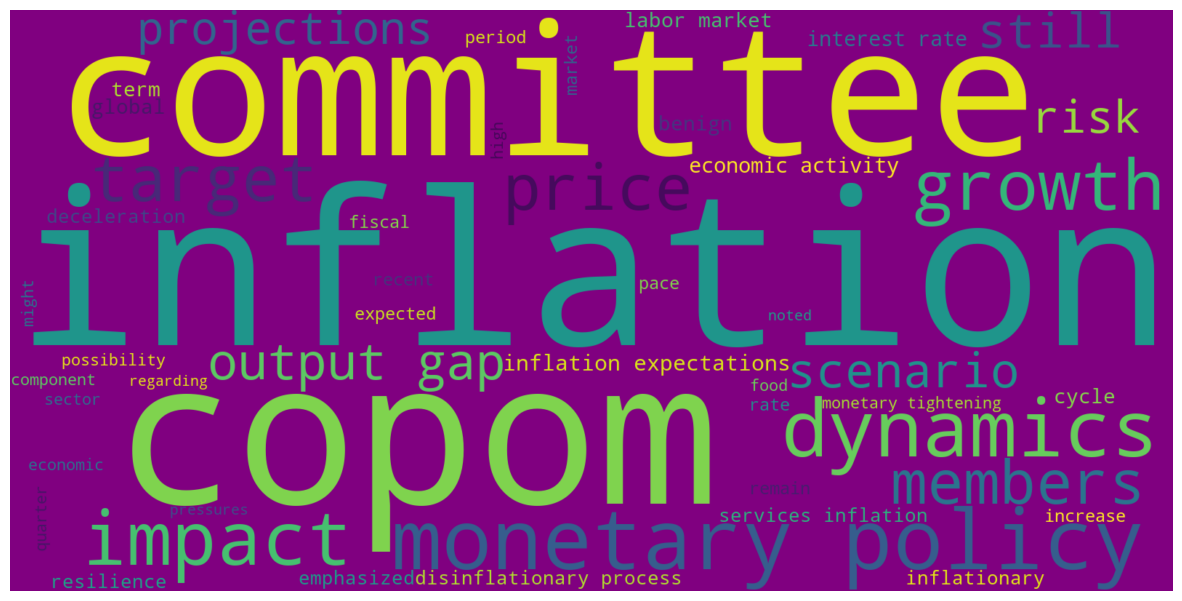

In [15]:
wordcloud_copom(minute_257[0])

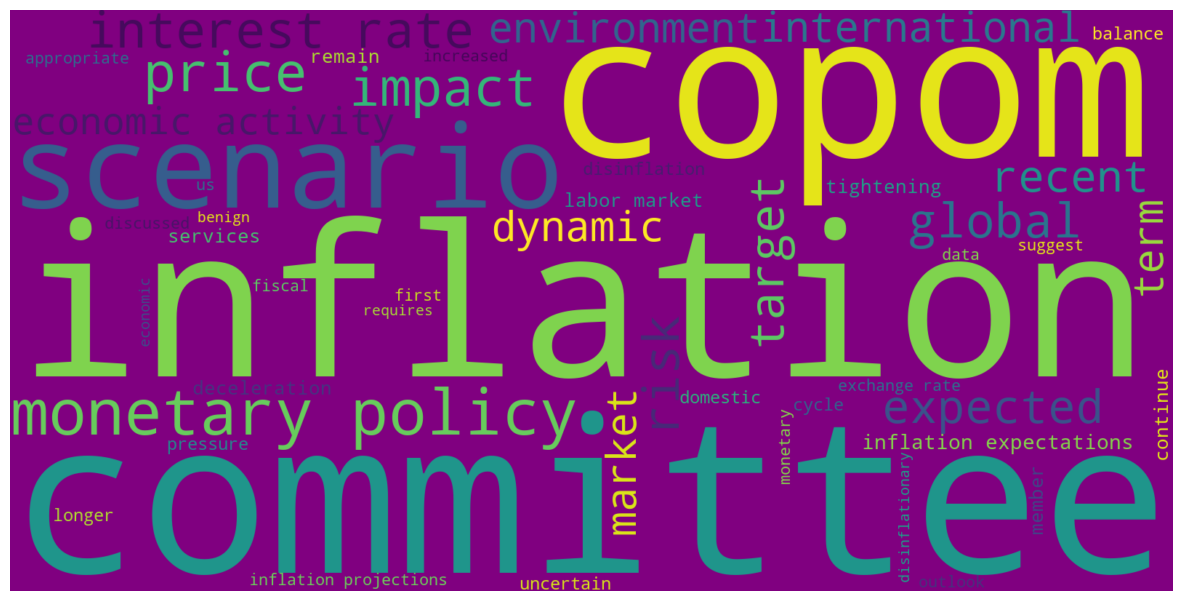

In [16]:
wordcloud_copom(minute_258[0])

#### **Comparação de frases/sentenças entre dois arquivos**

In [41]:
similaridade_sentencas(minutes_1=minute_258[0], minutes_2=minute_257[0])

O texto possui 28 tópicos.
O texto possui 26 tópicos.
------------------------------
Sentença do arquivo 1:  The global environment is adverse, due to an increase in longer-term interest rates in the United States, the persistence of high core inflation in many countries, and new geopolitical tensions.
Sentença do arquivo 2:  The Committee noted an increase in long-term interest rates in the United States as well as forecasts of lower growth in China, both demanding further attention from emerging market economies.
Similaridade:  0.538860103626943
------------------------------

Sentença do arquivo 1:  The Committee judges that the environment requires attention and caution from emerging market economies.
Sentença do arquivo 2:  The Committee evaluates that the international outlook is uncertain.
Similaridade:  0.5348837209302325
------------------------------

Sentença do arquivo 1:  Conversely, the labor market continues strong, albeit with some moderation at the margin.
Sentença do 

In [43]:
df_similar_text = similaridade_sentencas_df(minutes_1=minute_258[0], minutes_2=minute_257[0])
df_similar_text

,sentenca_arquivo_1,sentenca_arquivo_2,similaridade
49,The Committee maintains its firm commitment to...,The Committee maintains its firm commitment to...,1.000000
44,"Regarding the next steps, Copom members unanim...","Regarding the next steps, Copom members unanim...",1.000000
30,Copom highlighted the uncertainty surrounding ...,Copom highlighted the uncertainty surrounding ...,1.000000
31,Copom opted to incorporate a relatively small ...,Copom opted to incorporate a relatively small ...,1.000000
32,"In the end, it was unanimously concluded that ...","In the end, it was unanimously concluded that ...",1.000000
37,The Committee emphasizes that risks to its sce...,The Committee emphasizes that risks to its sce...,1.000000
38,Among the upside risks for the inflationary sc...,Among the upside risks for the inflationary sc...,1.000000
39,"Among the downside risks, it should be noted (...","Among the downside risks, it should be noted (...",1.000000
43,"After the scenario evaluation, all members agr...","After the scenario evaluation, all members agr...",1.000000
28,Copom still assesses that the inherent volatil...,Copom still assesses that the inherent volatil...,1.000000


#### **Transformando em um arquivo Word**


In [20]:
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_COLOR_INDEX

**Destacando apenas uma palavra no texto da ata**

In [25]:
# Criando um novo documento do Word
doc = Document()

# Texto da ata
texto = minute_258[0]

# Criando um parágrafo no documento
paragrafo = doc.add_paragraph()

# Dividindo o texto em palavras para processamento
palavras = texto.split()

# Percorrendo as palavras e adicionando-as ao parágrafo
for palavra in palavras:
    if 'inflation' in palavra.lower():
        # Se a palavra contém 'inflation' (ignorando maiúsculas/minúsculas), destaque-a em amarelo
        run = paragrafo.add_run(palavra + ' ')
        font = run.font
        font.highlight_color = WD_COLOR_INDEX.YELLOW
    else:
        # Caso contrário, adicione a palavra normalmente
        paragrafo.add_run(palavra + ' ')

# Número da ata
num_ata = 258

# Salvando o documento em um arquivo Word
doc.save(f'C://Users//vitor//projetos_python//python_b3//nlp-ata-copom//analise-ata-copom//copom//minutes-word//minute_{num_ata}.docx')

**Destacando sentenças que possuem similaridade igual a uma ata anterior**

In [42]:
# Criando um novo documento do Word
doc = Document()

# Número da ata
num_ata = 258

# Texto da ata completo
texto_minute = minute_258[0]

# Sentenças que possuem similaridade entre duas atas
# Destaque 'AMARELO' - senteças 100% iguais
filt = (df_similar_text['similaridade'] == 1)
similar_text = df_similar_text.loc[filt, 'sentenca_arquivo_1']

# Destaque 'AZUL' - senteças entre 80% e 99% iguais
filt_2 = (df_similar_text['similaridade'] >= 0.80) & (df_similar_text['similaridade'] <= 0.99)
similar_text_2 = df_similar_text.loc[filt_2, 'sentenca_arquivo_1']

# Separando o texto em sentenças usando o tokenizador 'nltk.sent_tokenize()'
sentencas = nltk.sent_tokenize(texto_minute)

# Percorrendo as sentenças e destacando aquelas que estão na série pandas
for sentenca in sentencas:
    if sentenca in similar_text.values:
        # Se a sentença está na série pandas, destaque-a em amarelo
        paragrafo = doc.add_paragraph()
        run = paragrafo.add_run(sentenca)
        font = run.font
        font.highlight_color = WD_COLOR_INDEX.YELLOW

    elif sentenca in similar_text_2.values:
        # Se a sentença está na série pandas, destaque-a em verde
        paragrafo = doc.add_paragraph()
        run = paragrafo.add_run(sentenca)
        font = run.font
        font.highlight_color = WD_COLOR_INDEX.GREEN

    else:
        # Caso contrário, adicione a sentença normalmente
        doc.add_paragraph(sentenca)

# Salvando o documento em um arquivo Word
doc.save(f'C://Users//vitor//projetos_python//python_b3//nlp-ata-copom//analise-ata-copom//copom//minutes-word//minute_{num_ata}.docx')

#### **Análise de Sentimento**

In [33]:
# O tópico "A" é o mais curto da ata, eu consigo analisar o sentimento dessa parte
print(sentiment_score(sentence=minute_258[1]))
print(sentiment_score_v2(sentence=minute_258[1]))

negative
positive


* O problema da análise de sentimento é de que você não pode passar um texto muito grande. Por isso, você você tem que separar o texto da ata em partes menores.



In [34]:
# Separando o texto do tópico "B" que é maior
partes_topico_b = text_splitter(minute=minute_258[2])
partes_topico_b

['5. In the reference scenario, the interest rate path is extracted from the Focus survey, and the exchange rate starts at USD/BRL 5.002 and evolves according to the purchasing power parity (PPP). The Committee assumes that oil prices follow approximately the futures market curve for the following six months and then start increasing 2% per year onwards. Moreover, the energy flag is assumed to be “green” in December 2023, 2024, and 2025. In this scenario, Copom’s inflation projections stand at 4.7% for 2023, 3.6% for 2024, and 3.2% for 2025. Inflation projections for administered prices are 9.3% for 2023, 5.0% for 2024, and 3.6% for 2025.',
 '6. The Committee evaluates that the international outlook is adverse. After the first disinflation stage following the normalization of productive chains, the early effects of the monetary policy tightening, and the reduction of pressures on commodities, Copom is focused on the disinflation sources for the next quarters. Amid an uncertain geopolit

In [35]:
# Após separar o tópico "B" em várias sentenças, eu posso analisar o sentimento de cada sentença
print(sentiment_score(sentence=partes_topico_b[2]))
print(sentiment_score_v2(sentence=partes_topico_b[2]))


neutral
negative


In [36]:
# Analisando o sentimento de todas as sentenças separadas ao mesmo tempo
text_splitter_sentiment_analysis(minute=minute_258[2])

De 16 sentenças:
- Nº de sentenças positivas: 3
- Nº de sentenças negativas: 1
- Nº de sentenças neutras: 12


### **Lendo o arquivo PDF**

In [1]:
from pypdf import PdfReader

import fitz  # PyMuPDF

# https://github.com/pypdfium2-team/pypdfium2
import pypdfium2 as pdfium

from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_COLOR_INDEX

**Visualizando o texto de uma ata**

In [ ]:
num_ata = 256

pdf_document = fitz.open(f"C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_{num_ata}.pdf")

# Loop pelas páginas do PDF
for page_number in range(pdf_document.page_count):
    page = pdf_document.load_page(page_number)
    
    # Extrai o texto da página
    page_text = page.get_text()
    
    # Imprime o texto da página
    print(f"Texto da página {page_number + 1}:\n")
    print(page_text)
    print("\n" + "-"*40 + "\n")

# Fecha o documento PDF
pdf_document.close()

**Visualizando a mesma página de várias atas**

In [ ]:
dict_minutes = {}

for num_minutes in range(240, 258):
    pdf_file_path = f'C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_{num_minutes}.pdf'
    reader = PdfReader(pdf_file_path)
    page = reader.pages[2]
    minutes_text = page.extract_text()
    dict_minutes[num_minutes] = minutes_text.strip()

dict_minutes

In [ ]:
IPython.display.Markdown(dict_minutes[257])

#### **Transformando o arquivo PDF em .txt**

In [15]:
num_ata = 200

doc = fitz.open(f"C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_{num_ata}.pdf") # open a document
out = open(f"minute_{num_ata}.txt", "wb") # create a text output
for page in doc: # iterate the document pages
	text = page.get_text().encode("utf8") # get plain text (is in UTF-8)
	out.write(text) # write text of page
	out.write(bytes((12,))) # write page delimiter (form feed 0x0C)
out.close()

#### **Transformando o arquivo PDF em Word**

In [86]:
num_ata = 257

doc = fitz.open(f"C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_{num_ata}.pdf")
docx_document = Document()

for page in doc:
    text = page.get_text()
    docx_document.add_paragraph(text)

docx_document.save(f"minute_{num_ata}.docx")

**Sublinhando uma palavra em específico no arquivo Word**

In [104]:
num_ata = 257

doc = fitz.open(f"C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_{num_ata}.pdf")
docx_document = Document()

for page in doc:
    text = page.get_text()
    paragraph = docx_document.add_paragraph()
    for word in text.split():
        run = paragraph.add_run(word)
        if 'inflation' in word.lower():
            # Destaque a palavra 'inflation' com a cor amarela
            font = run.font
            font.highlight_color = WD_COLOR_INDEX.YELLOW

docx_document.save(f"minute_{num_ata}.docx")


#### **Removendo as notas de rodapé e textos das bordas do PDF**

In [ ]:
# Caminho para o arquivo PDF
pdf_file = 'C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_256.pdf'

# Página do PDF que você deseja processar (índice baseado em zero)
page_number = 3

# Coordenadas do retângulo (x0, y0, x1, y1) em pontos (72 pontos = 1 polegada)
# Ajuste essas coordenadas para o retângulo desejado na página
# (X0, Y0) = (90, 90) -> retira o texto que está no canto superior direito que é (ex: '256th Meeting COPOM August 1-2')
rect = (90, 90, 720, 720)

# Abra o arquivo PDF
pdf_document = fitz.open(pdf_file)

# Obtenha a página desejada
page = pdf_document[page_number]

# Use o retângulo para selecionar a parte do texto
text = page.get_text("text", clip=rect)

# Feche o arquivo PDF
pdf_document.close()

# Exiba o texto extraído
print(text)

#### **Transformando as páginas do PDF em imagens**

In [ ]:
pdf = pdfium.PdfDocument('C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_257.pdf')
version = pdf.get_version()  # get the PDF standard version
n_pages = len(pdf)  # get the number of pages in the document

# Renderizando todas as páginas em imagens
page_indices = [i for i in range(n_pages)]  # all pages
renderer = pdf.render(
    pdfium.PdfBitmap.to_pil,
    page_indices = page_indices,
    scale = 300/72,  # 300dpi resolution
)
n_digits = len(str(n_pages))
for i, image in zip(page_indices, renderer):
    image.save("out_%0*d.jpg" % (n_digits, i+1))